In [10]:
# imports
import os
import numpy as np
import pickle
import sqlite3
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm
import dask
import cv2
import dask.array as da
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from sklearn.metrics import pairwise_distances
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors





### How Does Feature Extraction Work?

- **ResNet50** is a convolutional neural network (CNN) pretrained on the ImageNet dataset, which contains millions of images across thousands of categories.
- It processes the image through multiple layers to generate a high-dimensional vector (embedding) that represents the image's features.
- The embedding is a high-dimensional vector.
- The layers in the network apply convolutional filters to the input image, capturing local patterns such as edges, textures, and simple shapes.
- The pooling layers downsample the feature maps, reducing their dimensionality and making the model more computationally efficient.
- Fully connected layers at the end would normally classify the image based on the extracted features.
- For feature extraction, you use the output of the avg-pool layer.
- The output is a 2048-dimensional vector that captures a summary of the image's high-level features.

### What Does the Model Take into Consideration?

- **Edges and corners**: Simple patterns at lower layers.
- **Textures**: Patterns like fabric textures or foliage.
- **Shapes and object parts**: Intermediate layers capture shapes and parts of objects.
- **Objects and scenes**: Higher layers capture complex objects and their arrangements within scenes.

In [11]:
# Load the ResNet50 model pre-trained on ImageNet (taktes around 2 sec)
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)



### How does the preprocessing work and why is it necessary?

- The image gets loaded and then preprocessed to match the format of the ResNet50 model.
- This involves resizing the picture to 224x224 pixels, normalizing the pixel values, and adding an extra dimension.




In [22]:
# Function to extract embedding with error handling
def extract_embedding(img_path, model):
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load the image
        img_data = image.img_to_array(img)  # Convert the image to an array
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)  # Preprocess the image to match the input format from ResNet50
        embedding = model.predict(img_data)
        return embedding.flatten()  # Return the flattened result
    except Exception as error:
        print(f"Error processing {img_path}: {error}")
        return None

# Function to get all image paths in the folder
def get_image_paths(main_folder):
    image_paths = []
    for root, _, files in os.walk(main_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                image_paths.append(full_path)
    return image_paths


# Extract embeddings for all images in the directory with logging and progress bar
def extract_and_store_embeddings(image_paths, model, checkpoint_dir, batch_size=32, checkpoint_interval=50000):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    embeddings = []
    valid_image_paths = []

    start_index = 0

    # Check if there is a checkpoint to resume from
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')])
    if checkpoint_files:
        last_checkpoint = checkpoint_files[-1]
        try:
            with open(os.path.join(checkpoint_dir, last_checkpoint), 'rb') as f:
                data = pickle.load(f)
                if len(data) == 3:
                    start_index, embeddings, valid_image_paths = data
                    print(f"Resuming from checkpoint {last_checkpoint}")
                else:
                    print(f"Unexpected checkpoint format in {last_checkpoint}. Starting from scratch.")
        except Exception as e:
            print(f"Error loading checkpoint {last_checkpoint}: {e}. Starting from scratch.")
    
    @delayed
    def process_batch(batch, batch_index):
        batch_embeddings = []
        batch_valid_image_paths = []
        for img_path in batch:
            embedding = extract_embedding(img_path, model)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_image_paths.append(img_path)
        
        # Save checkpoint at intervals
        if (batch_index + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{batch_index + 1}.pkl")
            with open(checkpoint_path, 'wb') as f:
                pickle.dump((batch_index + 1, embeddings + batch_embeddings, valid_image_paths + batch_valid_image_paths), f)
            print(f"Saved checkpoint at batch index {batch_index + 1}")
        
        return batch_embeddings, batch_valid_image_paths

    # Create batches
    batches = [image_paths[i:i + batch_size] for i in range(start_index, len(image_paths), batch_size)]

    # Process batches in parallel
    results = [process_batch(batch, i + start_index) for i, batch in enumerate(batches)]
    results = compute(*results)

    # Combine results
    all_embeddings = np.concatenate([result[0] for result in results])
    all_valid_image_paths = sum([result[1] for result in results], [])

    if len(all_embeddings) == 0:
        raise ValueError("No valid embeddings were extracted. Check the image paths and processing.")
    return all_embeddings, all_valid_image_paths

# Function to find similar images
def find_similar_images(input_img_path, model, embeddings, image_paths, top_n=5):
    input_embedding = extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    indices = np.argsort(similarities)[::-1][:top_n] # sort by similarity
    similar_images = [(image_paths[i], similarities[i]) for i in indices]
    return similar_images

# Save embeddings and image paths
def save_embeddings_and_paths(embeddings, image_paths, embeddings_path, image_paths_path):
    with open(embeddings_path, 'wb') as f:
        pickle.dump(embeddings, f)  # Write embeddings in pickle file
    with open(image_paths_path, 'wb') as f:
        pickle.dump(image_paths, f)  # Write image_paths in pickle file

# Load embeddings and image paths
def load_embeddings_and_paths(embeddings_path, image_paths_path):
    with open(embeddings_path, 'rb') as f:
        embeddings = pickle.load(f)
    with open(image_paths_path, 'rb') as f:
        image_paths = pickle.load(f)
    return embeddings, image_paths

def display_images(input_image_path, similar_images):
    """
    This function visually displays the input image alongside its most similar images found in the database.

    Input: 
    - input_image_path: A string representing the file path of the input image.
    - similar_images: A list of tuples, where each tuple contains an image path and the corresponding similarity distance.

    Output: 
    - The function does not return anything. It displays the images in a Matplotlib figure.

    The input image is loaded and converted from BGR to RGB color space.
    A plot is created with the input image on the left and the similar images on the right. Each similar image is labeled with its similarity distance.
    The function uses Matplotlib to display the images in a grid layout.
    
    """
    input_image = cv2.imread(input_image_path)
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20, 5))
    
    # Plot input image
    plt.subplot(1, 6, 1)
    plt.imshow(input_image_rgb)
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot similar images
    for i, (image_path, distance) in enumerate(similar_images, start=2):
        similar_image = cv2.imread(image_path)
        similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, i)
        plt.imshow(similar_image_rgb)
        plt.title(f'Similar {i-1}\nDist: {distance:.2f}')
        plt.axis('off')
    
    plt.show()

# Function to display images
def display_images_from_paths(image_paths):
    plt.figure(figsize=(20, 5))
    for i, image_path in enumerate(image_paths, start=1):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(image_rgb)
        plt.title(f'Image {i}')
        plt.axis('off')
    plt.show()


### How Does the Similarity Calculation Work?

- Cosine similarity measures the cosine of the angle between two vectors, providing a value between -1 (opposite) and 1 (the same).
- Cosine similarity is useful for comparing high-dimensional vectors because it measures the orientation of the vectors rather than their magnitude.
- This is beneficial because vectors might have different magnitudes but still represent similar content.

### What is special about the cosine similarity?
- focuses on the direction of the vectors, which means two vectors with the same direction but different magnitudes will be considered similar
- cosine similarity remains effective because it normalizes the vectors to unit length before measuring the angle between them


In [13]:
"""
embeddings_path = 'embeddings_all.pkl'
image_paths_path = 'image_paths_all.pkl'

if not os.path.exists(embeddings_path) or not os.path.exists(image_paths_path):
    image_paths = get_image_paths(main_folder)
    with ProgressBar():
        embeddings, valid_image_paths = extract_and_store_embeddings(image_paths, model, checkpoint_dir)
    save_embeddings_and_paths(embeddings, valid_image_paths, embeddings_path, image_paths_path)
else:
    embeddings, valid_image_paths = load_embeddings_and_paths(embeddings_path, image_paths_path)
"""

"\nembeddings_path = 'embeddings_all.pkl'\nimage_paths_path = 'image_paths_all.pkl'\n\nif not os.path.exists(embeddings_path) or not os.path.exists(image_paths_path):\n    image_paths = get_image_paths(main_folder)\n    with ProgressBar():\n        embeddings, valid_image_paths = extract_and_store_embeddings(image_paths, model, checkpoint_dir)\n    save_embeddings_and_paths(embeddings, valid_image_paths, embeddings_path, image_paths_path)\nelse:\n    embeddings, valid_image_paths = load_embeddings_and_paths(embeddings_path, image_paths_path)\n"

## Connecting to the Database and loading the Embeddings

In [14]:
# creating a database using sql lite
database_name = "database_all_images.db"
root_folder = r"D:/data/image_data"

conn = sqlite3.connect(database_name)
c = conn.cursor()
conn.commit()

c.execute("SELECT Path FROM Images")

# Fetch all results
paths_tuples = c.fetchall()  # This will be a list of tuples

# Convert list of tuples to a list of strings
database_image_paths = [path[0] for path in paths_tuples]  # Extract the first element of each tuple

# Verify the paths
for path in database_image_paths[:10]:  # Print the first 10 paths for verification
    print(path)



D:/data/image_data\weather_image_recognition\dew\2208.jpg
D:/data/image_data\weather_image_recognition\dew\2209.jpg
D:/data/image_data\weather_image_recognition\dew\2210.jpg
D:/data/image_data\weather_image_recognition\dew\2211.jpg
D:/data/image_data\weather_image_recognition\dew\2212.jpg
D:/data/image_data\weather_image_recognition\dew\2213.jpg
D:/data/image_data\weather_image_recognition\dew\2214.jpg
D:/data/image_data\weather_image_recognition\dew\2215.jpg
D:/data/image_data\weather_image_recognition\dew\2216.jpg
D:/data/image_data\weather_image_recognition\dew\2217.jpg


In [15]:
embeddings_path = 'embeddings_all.pkl'
with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)




In [16]:
def display_images(input_image_path, similar_images):
    """
    This function visually displays the input image alongside its most similar images found in the database.

    Input: 
    - input_image_path: A string representing the file path of the input image.
    - similar_images: A list of tuples, where each tuple contains an image path and the corresponding similarity distance.

    Output: 
    - The function does not return anything. It displays the images in a Matplotlib figure.

    The input image is loaded and converted from BGR to RGB color space.
    A plot is created with the input image on the left and the similar images on the right. Each similar image is labeled with its similarity distance.
    The function uses Matplotlib to display the images in a grid layout.
    
    """
    input_image = cv2.imread(input_image_path)
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20, 5))
    
    # Plot input image
    plt.subplot(1, 6, 1)
    plt.imshow(input_image_rgb)
    plt.title('Input Image')
    plt.axis('off')
    
    print("Preparing Plot...")
    # Plot similar images
    for i, (image_path, distance) in enumerate(similar_images, start=2):
        similar_image = cv2.imread(image_path)
        similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, i)
        plt.imshow(similar_image_rgb)
        plt.title(f'Similar {i-1}\nDist: {distance:.2f}')
        plt.axis('off')
    
    print("Showing Plot...")

    plt.show()

In [17]:
def find_similar_images(input_img_path, model, embeddings, image_paths, top_n=5):
    """
    This function finds images in the database that are most similar to the input image based on embeddings.

    Input:
    - input_img_path: The file path of the input image.
    - model: The model used to extract embeddings.
    - embeddings: A NumPy array containing the embeddings of all images in the database.
    - image_paths: A list of paths to the images corresponding to the embeddings.
    - top_n: An integer specifying the number of similar images to return (default is 5).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding normalized similarity score. 
      The list is ordered by similarity, with the most similar image first.
    """
    # Extract embedding for the input image
    input_embedding = extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    
    # Use Nearest Neighbors for efficient similarity search
    nbrs = NearestNeighbors(n_neighbors=len(embeddings), algorithm='auto', metric='euclidean').fit(embeddings)
    
    distances, indices = nbrs.kneighbors([input_embedding])
    
    # Normalize the distances using the global min and max distances across the entire dataset
    global_min_distance = np.min(distances)
    global_max_distance = np.max(distances)
    
    normalized_distances = (distances - global_min_distance) / (global_max_distance - global_min_distance)

    # Retrieve the most similar images with normalized distances
    similar_images = [(image_paths[idx], normalized_distances[0][i]) for i, idx in enumerate(indices[0][:top_n])]
    
    return similar_images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
['D:/data/image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0183.png', 'D:/data/image_data\\pexels_dataset_v1\\images_01\\black-cat-near-tree-in-nature-5403252.jpeg', 'D:/data/image_data\\pixabay_dataset_v1\\images_02\\cabinet-furniture-bedroom-interior-4705299.jpg', 'D:/data/image_data\\pixabay_dataset_v1\\images_01\\butterfly-insect-animal-142506.jpg', 'D:/data/image_data\\pixabay_dataset_v1\\images_01\\butterfly-lepidoptera-plant-insect-7386536.jpg']
Preparing Plot...
Showing Plot...


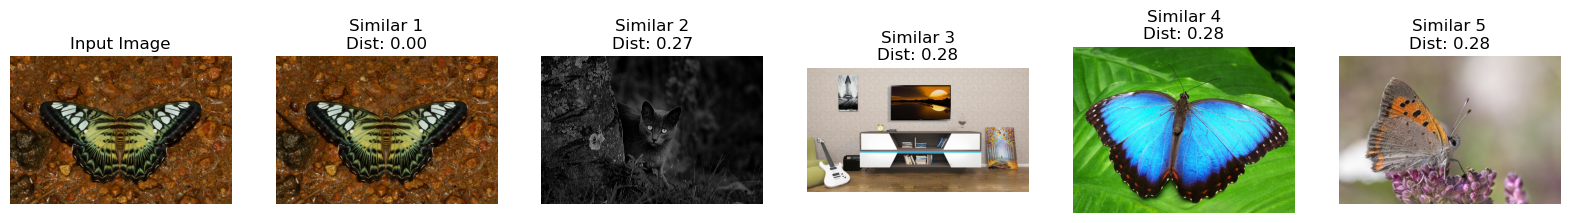

In [20]:
# set paths and find 
input_img_path = "images/0183.png"
similar_images = find_similar_images(input_img_path, model, embeddings, database_image_paths, top_n=5)

top_5_paths = []
#top_5_paths.append(input_img_path)
# Display similar images
for img_path, similarity in similar_images:
    #print(f"Image: {img_path}, Similarity: {similarity:.2f}")
    top_5_paths.append(img_path)
print(top_5_paths)    
# Display the images
display_images(input_img_path, similar_images)
# Display similar images


In [19]:
# This code takes arouund 200 seconds for 1000 images. 
# this would be a time of 27 hours for 500.000 images

In [8]:
print(embeddings[1])
print(f"The shape of the embedding is {embeddings.shape}")
print(f"The max value of the embedding array is {np.max(embeddings)} and the min is {np.min(embeddings)}")
print(f"There are {len(valid_image_paths)} image paths")
assert(len(valid_image_paths) == embeddings.shape[0])

[3.1913400e+00 1.0725763e-01 1.7299149e+00 ... 6.8629223e-01 3.1839585e-04
 1.0422593e+00]
The shape of the embedding is (444673, 2048)
The max value of the embedding array is 53.297245025634766 and the min is 0.0
There are 444673 image paths


## Finding the closest image to 5 input images. 

Steps in the computation (look further up to know how the embeddings are calculated)
- Compute the mean value for each of the 2048 dimensions across all the input embeddings. 

### What happens if we input 5 completely random images?
- the algorithm will search for an image whose embedding is closest to this averaged embedding
- because the mean embedding is an aggregate of very diverse features, it might reuslt in selecting an image that contains some common elements or patterns found across the random images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: D:/data/image_data\pixabay_dataset_v1\images_03\flowers-nature-people-woman-girl-3160012.jpg, Similarity: 0.0
Image: D:/data/image_data\pixabay_dataset_v1\images_03\inside-architecture-empty-glass-3222128.jpg, Similarity: 0.0017415806360639547
Image: D:/data/image_data\pixabay_dataset_v1\images_03\garlic-spices-aroma-flavour-food-1808.jpg, Similarity: 0.003959664405901973
Image: D:/data/image_data\pexels_dataset_v1\images_02\computer-set-on-table-2811648.jpeg, Similarity: 0.005163982441985862
Image: D:/data/image_data\DIV2k\DIV2K_valid_HR\DIV2K_valid_HR\0853.png, Similarity: 0.011194314688827272


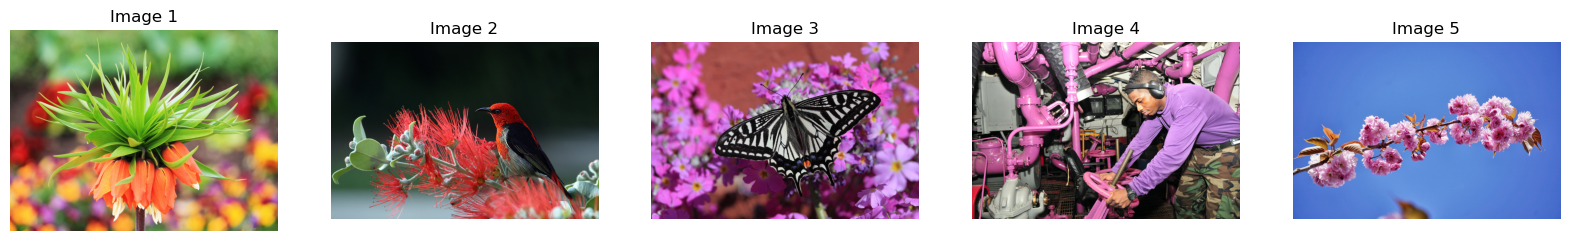

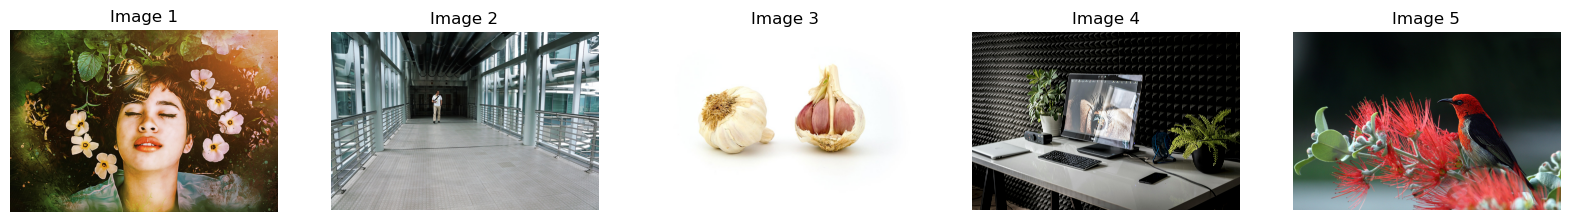

In [24]:

def average_embeddings(input_image_paths, model):
    embeddings = [extract_embedding(img_path, model) for img_path in input_image_paths]
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

def find_similar_images_to_group(input_img_paths, model, embeddings, image_paths, top_n=5):
    """
    This function finds images in the database that are most similar to the summarized input images 
    based on embeddings.

    Input:
    - input_img_paths: A list of file paths of the input images.
    - model: The model used to extract embeddings.
    - embeddings: A NumPy array containing the embeddings of all images in the database.
    - image_paths: A list of paths to the images corresponding to the embeddings.
    - top_n: Number of top similar images to select based on embeddings (default is 5).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding similarity score.
      The list is ordered by similarity, with the most similar image first.
    """
    # Step 1: Extract embeddings for all input images and calculate the summarized embedding
    input_embeddings = []
    
    for img_path in input_img_paths:
        embedding = extract_embedding(img_path, model)  # Assuming `extract_embedding` is a function in your environment
        if embedding is not None:
            input_embeddings.append(embedding)
        else:
            print(f"Failed to extract embedding for input image: {img_path}")

    if not input_embeddings:
        print("No valid embeddings found for the input images.")
        return []

    # Step 2: Calculate the summarized embedding by averaging the embeddings
    summarized_embedding = np.mean(input_embeddings, axis=0)

    # Step 3: Use the summarized embedding to find the top N closest images
    nbrs_embeddings = NearestNeighbors(n_neighbors=len(embeddings), algorithm='auto', metric='euclidean').fit(embeddings)
    distances_embeddings, indices_embeddings = nbrs_embeddings.kneighbors([summarized_embedding])

    # Normalize embedding distances globally
    min_embedding_distance = np.min(distances_embeddings)
    max_embedding_distance = np.max(distances_embeddings)
    normalized_embedding_distances = (distances_embeddings - min_embedding_distance) / (max_embedding_distance - min_embedding_distance)

    # Retrieve the top N similar images based on normalized embedding distances
    similar_images = [(image_paths[indices_embeddings[0][i]], normalized_embedding_distances[0][i]) for i in range(top_n)]
    
    return similar_images

# Example usage
input_image_paths = [
    "images/0803.png",
    "images/0853.png",
    "images/0882.png",
    "images/0888.png",
    "images/0898.png"
]


top_5_paths_from_5_images = []
similar_images = find_similar_images_to_group(input_image_paths, model, embeddings, database_image_paths)
for img_path, similarity in similar_images:
    print(f"Image: {img_path}, Similarity: {similarity}")
    top_5_paths_from_5_images.append(img_path)

display_images_from_paths(input_image_paths)
display_images_from_paths(top_5_paths_from_5_images)



### Other approach: Aggregated distance metric

Compute the distance from each candidate image to each of the 5 input images, then aggregate these distances.
The candidate image with the smallest aggregated distance is considered the closest match

### How is the distance calculated in the aggregated distance metric?

The aggregated distance metric is based on cosine similarity, which calculates the similarity between two vectors as the cosine of the angle between them
Formula for the cosine similarity: (A * B) / (||A|| x ||B||)

In [ ]:
def aggregate_distances(input_image_paths, model, all_image_embeddings, all_image_paths, top_n=5):
    input_embeddings = [extract_embedding(img_path, model) for img_path in input_image_paths]
    aggregated_distances = []

    for i, candidate_embedding in enumerate(all_image_embeddings):
        distances = [cosine_similarity([candidate_embedding], [input_embedding])[0][0] for input_embedding in input_embeddings]
        aggregated_distance = np.mean(distances)
        aggregated_distances.append((all_image_paths[i], aggregated_distance))

    aggregated_distances.sort(key=lambda x: x[1], reverse=True)
    return aggregated_distances[:top_n]

# Example usage
input_image_paths = [
    "Test\chinese-style-5857819_640.jpg",
    "Test\Gewitter.jpg",
    "Test\Kemelion.jpg",
    "Test\Krokodil.jpg",
    "Test\Pferd_auf_Wiese.jpg"
]

similar_images = aggregate_distances(input_image_paths, model, embeddings, valid_image_paths)
scnd_method_top5 = []
for img_path, distance in similar_images:
    print(f"Image: {img_path}, Aggregated Distance: {distance}")
    scnd_method_top5.append(img_path)

display_images_from_paths(input_image_paths)
display_images_from_paths(scnd_method_top5)
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


KeyboardInterrupt: 

In [ ]:
# In order to see the runtime 
snakeviz profiling_results.prof
